In [1]:
import pandas as pd
import numpy as np
import os
from os.path import join
import seaborn as sns
import matplotlib.pyplot as plt
from pigeon import annotate

In [2]:
labels_df = pd.read_csv(join("data", "cis-pd", "data_labels", "CIS-PD_Training_Data_IDs_Labels.csv"))
labels_df = labels_df.sort_values(by="tremor", ascending=False).reset_index(drop=True)

In [3]:
labels_df.head()

,measurement_id,subject_id,on_off,dyskinesia,tremor
0,4913062f-b696-40c6-a0f2-87efe1dd4810,1048,3.0,3.0,4.0
1,7b2698a6-f3a5-4345-9630-25d377d58992,1048,2.0,3.0,4.0
2,40f713fe-0ac9-4cd0-809c-0a8024955a2a,1048,3.0,3.0,4.0
3,e0441156-c4b8-467c-8f4f-3b532d594d8f,1048,4.0,3.0,4.0
4,daf11494-e6fa-4376-a78a-86c683885764,1004,4.0,4.0,4.0


In [4]:
m_id = "7b2698a6-f3a5-4345-9630-25d377d58992" # put a measurement ID to annotate here

m_df = pd.read_csv(join("data", "cis-pd", "training_data", f"{m_id}.csv"))
m_df.head()

,Timestamp,X,Y,Z
0,0.00,-0.962158,0.249512,-0.152100
1,0.02,-0.936523,0.267578,-0.180176
2,0.04,-0.927979,0.282471,-0.230225
3,0.06,-0.922852,0.302979,-0.313477
4,0.08,-0.922119,0.292725,-0.335938


In [5]:
interval_size = 0.5
interval_min = m_df["Timestamp"].min()
interval_max = m_df["Timestamp"].max()

flatness_threshold = 0.005

In [6]:
def is_flat_interval(interval_start):
    interval_end = interval_start + interval_size
    interval_df = m_df.loc[(m_df["Timestamp"] >= interval_start) & (m_df["Timestamp"] < interval_end)]
    X_stdev = np.std(interval_df["X"].values)
    Y_stdev = np.std(interval_df["Y"].values)
    Z_stdev = np.std(interval_df["Z"].values)
        
    if X_stdev < flatness_threshold and Y_stdev < flatness_threshold and Z_stdev < flatness_threshold:
        return True
    return False

In [7]:
all_intervals = set(list(np.arange(interval_min, interval_max, interval_size)))
flat_intervals = set()
for interval_start in all_intervals:
    if is_flat_interval(interval_start):
        flat_intervals.add(interval_start)

non_flat_intervals = sorted(list(set(all_intervals - flat_intervals)))

/Users/mkeller/anaconda3/envs/beat-pd-mark-env/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/mkeller/anaconda3/envs/beat-pd-mark-env/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/mkeller/anaconda3/envs/beat-pd-mark-env/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
flat_annotations = [(x, 'no_tremor.flat') for x in list(flat_intervals)]

In [9]:
print(f"Detected {len(flat_annotations)} flat intervals")

Detected 18 flat intervals


In [10]:
m_molten_df = m_df.melt(id_vars=["Timestamp"], value_vars=["X", "Y", "Z"], var_name="dim")
m_molten_df.head()

,Timestamp,dim,value
0,0.00,X,-0.962158
1,0.02,X,-0.936523
2,0.04,X,-0.927979
3,0.06,X,-0.922852
4,0.08,X,-0.922119


In [11]:
def display_interval(interval_start):
    interval_end = interval_start + interval_size
    extended_interval_molten_df = m_molten_df.loc[(m_molten_df["Timestamp"] >= interval_start - interval_size) & (m_molten_df["Timestamp"] < interval_end + interval_size)]
    left_molten_df = extended_interval_molten_df.loc[(extended_interval_molten_df["Timestamp"] >= interval_start - interval_size) & (extended_interval_molten_df["Timestamp"] < interval_start)]
    interval_molten_df = extended_interval_molten_df.loc[(extended_interval_molten_df["Timestamp"] >= interval_start) & (extended_interval_molten_df["Timestamp"] < interval_end)]
    right_molten_df = extended_interval_molten_df.loc[(extended_interval_molten_df["Timestamp"] >= interval_end) & (extended_interval_molten_df["Timestamp"] < interval_end + interval_size)]
    
    fig, axes = plt.subplots(1, 3, sharey=True, figsize=(14, 5))

    ax = sns.lineplot(x="Timestamp", y="value", hue="dim", ax=axes[0], data=left_molten_df)
    ax.set_axis_off()
    ax.get_legend().remove()
    ax = sns.lineplot(x="Timestamp", y="value", hue="dim", ax=axes[1], data=interval_molten_df)
    ax = sns.lineplot(x="Timestamp", y="value", hue="dim", ax=axes[2], data=right_molten_df)
    ax.set_axis_off()
    ax.get_legend().remove()
    plt.ylim(-1.3, 1.3)
    plt.show()

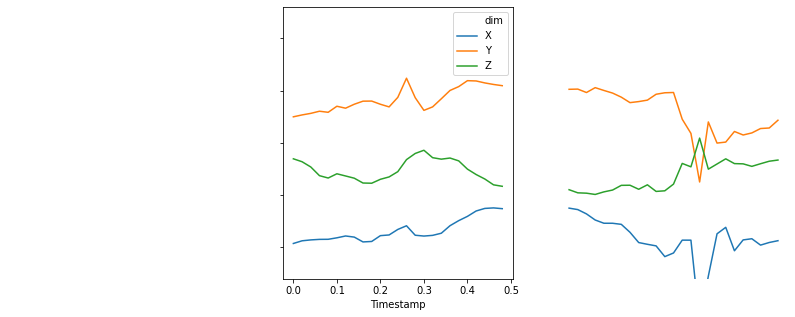

In [12]:
annotations = annotate(
  non_flat_intervals,
  options=['tremor', 'no_tremor'],
  display_fn=lambda interval_start: display_interval(interval_start)
)

In [17]:
annotations

[(0.0, 'no_tremor'),
 (0.5, 'no_tremor'),
 (1.0, 'no_tremor'),
 (1.5, 'no_tremor'),
 (2.0, 'no_tremor'),
 (2.5, 'no_tremor'),
 (3.0, 'no_tremor'),
 (3.5, 'no_tremor'),
 (4.0, 'no_tremor'),
 (4.5, 'no_tremor'),
 (5.0, 'no_tremor'),
 (5.5, 'no_tremor'),
 (6.0, 'no_tremor'),
 (6.5, 'no_tremor'),
 (7.0, 'no_tremor'),
 (7.5, 'no_tremor'),
 (8.0, 'no_tremor'),
 (8.5, 'no_tremor'),
 (9.0, 'no_tremor'),
 (9.5, 'no_tremor'),
 (10.0, 'no_tremor'),
 (10.5, 'no_tremor'),
 (11.0, 'no_tremor'),
 (11.5, 'no_tremor'),
 (12.0, 'no_tremor'),
 (12.5, 'no_tremor'),
 (13.0, 'no_tremor'),
 (13.5, 'no_tremor'),
 (14.0, 'no_tremor'),
 (14.5, 'no_tremor'),
 (15.0, 'no_tremor'),
 (15.5, 'no_tremor'),
 (16.0, 'no_tremor'),
 (16.5, 'no_tremor'),
 (17.0, 'no_tremor'),
 (17.5, 'no_tremor'),
 (18.0, 'no_tremor'),
 (18.5, 'no_tremor'),
 (19.0, 'no_tremor'),
 (19.5, 'no_tremor'),
 (20.0, 'no_tremor'),
 (20.5, 'no_tremor'),
 (21.0, 'no_tremor'),
 (21.5, 'no_tremor'),
 (22.0, 'no_tremor'),
 (22.5, 'no_tremor'),
 (23.0, 

In [18]:
a_dicts = [ { "interval_start": x[0], "annotation": x[1] } for x in (annotations + flat_annotations) ]

In [19]:
a_df = pd.DataFrame(data=a_dicts)
a_df = a_df.sort_values(by="interval_start", ascending=True)
a_df.head()

,interval_start,annotation
0,0.0,no_tremor
1,0.5,no_tremor
2,1.0,no_tremor
3,1.5,no_tremor
4,2.0,no_tremor


In [1]:
if a_df.shape[0] >= 100:
    a_df.to_csv(join("data", "cis-pd", "training_data_tremor_annotations", f"{m_id}.csv"), index=False)

NameError: name 'a_df' is not defined